### Soil water balance module
Based on: Global land-surface evaporation estimated from satellite-based
observations

In [1]:
from data_processing import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from infiltration_models import *
import os
from model_processes import *

#segoe ui font
plt.rcParams['font.sans-serif'] = "Segoe UI"

### Parameters

In [2]:
alpha_tall_canopy = 0.8
alpha_short_canopy = 1.26 #short veg. and bare soil
frac_tall_canopy = 0.5
frac_short_canopy = 0.3
frac_bare_soil = 0.2
beta = 0.07
s_fc = 0.321
s_sat = 0.482
s_wp = 0.137
Ks=12.19 #Saturated hydraulic conductivity in mm/h (Silt Loam) -->>> from SPAW model
S=34.3 #Sorptivity in mm/h^0.5

LAI = 3.5
tau = 0.8 #or 0.2 a parameter accounting for the development of vegetation over the year (vegetation optical depth).

### Input data

In [3]:
#calculate PET from  data in data_processing.py
#source directory
src=r"W:\VUB\_main_research\scripts\wetland_model\conceptual_model\data"

pET_k = 0.408 * (delta/(delta + gamma)) * net_radiation
precip=pd.read_csv(os.path.join(src,"Boechout_precip_ETo.csv"), index_col=0)
precip.index=pd.to_datetime(precip.index, format='%d/%m/%Y')

#surface soil moisture data extracted from SMAP
smap_ssm=pd.read_excel(src+"/smap_surface_sm_boechout_9km.xlsx", index_col=0)
smap_ssm.index=pd.to_datetime(smap_ssm.index) 

### Soil moisture simulation

In [6]:
# Time loop
dt = 1  # Time step in days
for time in range(1, len(pET_k) - 1):
    (interception, total_evap, evap_actual_tc, evap_actual_sc, evap_actual_bs, 
     AWC, infil, perco, sm) = simulate_soil_water_balance(
        time, sm, pET_k, precip, LAI, s_fc, s_wp, tau, soil_depth, Ks, S, dt,
        frac_tall_canopy, frac_short_canopy, frac_bare_soil, alpha_tall_canopy, 
        alpha_short_canopy, interception, total_evap, evap_actual_tc, 
        evap_actual_sc, evap_actual_bs, AWC, infil, perco
    )

#### Outputs: Transform arrays to dataframes

In [7]:
#convert arrays to pandas series
model_arrays = [interception, total_evap, evap_actual_tc, evap_actual_sc, evap_actual_bs, 
     AWC, infil, perco, sm]
array_names = ['interception', 'total_evap', 'evap_actual_tc', 'evap_actual_sc', 'evap_actual_bs', 
     'AWC', 'infil', 'perco', 'sm']


model_df = pd.DataFrame(model_arrays, index=array_names).T
model_df.index = pET_k.index

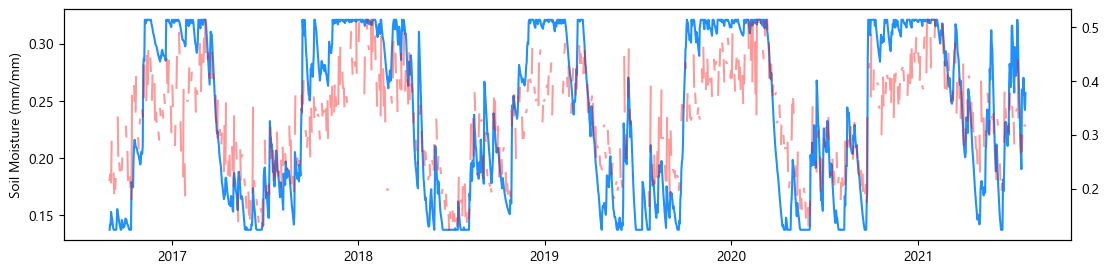

In [8]:
start_date='2016-09-01'
end_date='2021-07-31'

fig,ax=plt.subplots(figsize=(13,3))
ax1 = ax.twinx()
#plt.plot(500*perco[200:4800])
#plt.plot(E_stress_bs)[200:-1]
ax.plot(model_df['sm'][start_date:end_date], color='dodgerblue')
ax1.plot(smap_ssm['soil_moisture_am'][start_date:end_date], c='red', alpha=0.4)
#ax1.plot(model_df['Available Water Capacity'][start_date:end_date], c='red', alpha=0.3)
ax.set_ylabel('Soil Moisture (mm/mm)');

In [9]:
#monthly percolation
monthly_perco = model_df['perco'].resample('ME').sum()
(monthly_perco).groupby(monthly_perco.index.year).sum().mean()

299.1985188635286

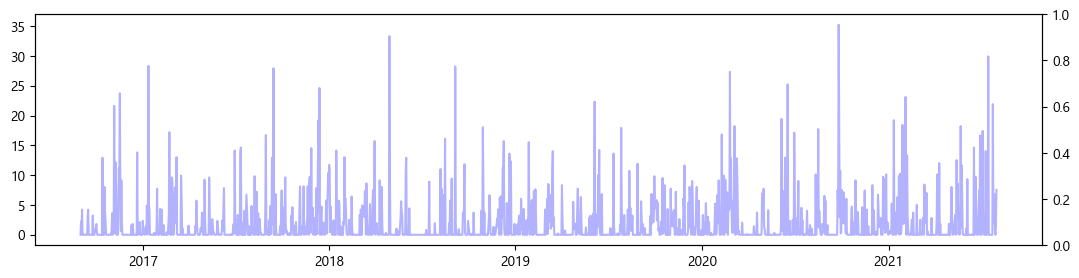

In [10]:
fig,ax=plt.subplots(figsize=(13,3))
ax1 = ax.twinx()
# plt.plot(model_df['Evap tall canopy'][start_date:end_date], c='m')
# plt.plot(model_df['Evap short canopy'][start_date:end_date], c='limegreen')
# plt.plot(model_df['Evap bare soil'][start_date:end_date], c = 'orange')
# plt.plot(model_df['Total Evapotranspiration'][start_date:end_date])
# plt.plot(pET_k[start_date:end_date], c =  'black', alpha=0.3)
# plt.ylabel('Evapotranspiration (mm/day)')
ax.plot(model_df['infil'][start_date:end_date], c='blue', alpha=0.3)


### Water Balance

In [13]:
#compute water balance
#output fluxes
annual_fluxes = model_df.resample('YE').sum().mean()

#input fluxes
precip_annual = precip['precipitation'].resample('YE').sum().mean()

wb = precip_annual - annual_fluxes['perco'] - annual_fluxes['total_evap'] #- annual_fluxes['run off']

#excess water
excess_water = precip['precipitation'] - model_df['perco'] - model_df['total_evap']

In [15]:
print('Annual Water balance:')
print('-----------------------------')

print('Precipitation:', np.round(precip_annual,2))
print('Total Evapotranspiration:', np.round(annual_fluxes['total_evap'].sum(),2))
print('Percolation:', np.round(annual_fluxes['perco'].sum(),2))
print('Run off:', )
print('Water balance:', np.round(wb,2))

Annual Water balance:
-----------------------------
Precipitation: 827.96
Total Evapotranspiration: 512.08
Percolation: 299.2
Run off:
Water balance: 16.68


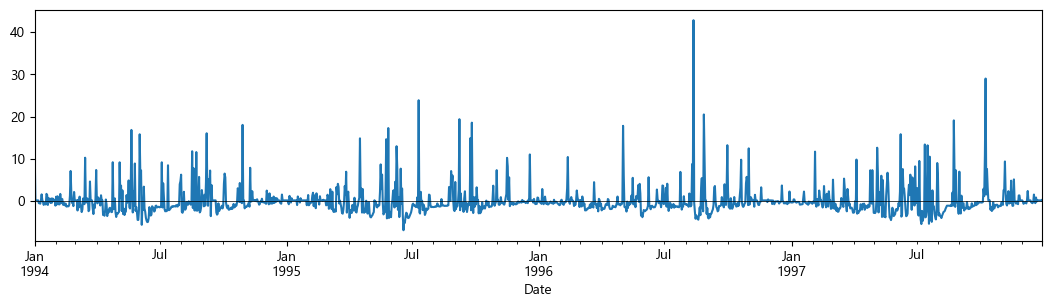

In [16]:
excess_water[0:1460].plot(figsize=(13,3))
plt.axhline(0, color='black', lw=0.5)